<a href="https://colab.research.google.com/github/so-dipe/Data-Science-and-Machine-Learning-Projects/blob/main/Tabular_Playground_Competition(Google).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c tabular-playground-series-may-2022

100% 257M/257M [01:04<00:00, 4.64MB/s]
100% 257M/257M [01:04<00:00, 4.20MB/s]


In [83]:
! unzip /content/tabular-playground-series-may-2022.zip

Archive:  /content/tabular-playground-series-may-2022.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
! pip install tensorflow_decision_forests

In [ ]:
class StackingClassifierEstimator:
  trained_models = None
  # pred_df = None
  
  def __init__(self, estimators, final_estimator, neuralnet_models=None, cv=None):
    self.estimators = estimators
    self.neuralnet_models = neuralnet_models
    self.cv = cv
    self.final_estimator = final_estimator
    pass
  
  def fit(self, X, y):
    trained_models = []
    for model in self.estimators:
      if self.cv is not None and self.cv > 0:
        kf = KFold(n_splits=self.cv, shuffle=True)
        i = 1
        for train_index, test_index in kf.split(X_train):
          print(f'training {i} for {model}')
          model.fit(X.iloc[train_index], y.iloc[train_index])
          model.score(X.iloc[train_index], y.iloc[train_index])
          model.score(X.iloc[test_index], y.iloc[test_index])
          trained_models.append(model)
          i = i + 1
      else:
        print(f'training {model}')
        model.fit(X, y)
        model.score(X, y)
        trained_models.append(model)
    self.trained_models = trained_models
    return trained_models

  # trained_models = trained_models

  def create_pred_df(self, X, y):
    preds = dict()
    # trained_models = self.fit(X, y)
    i = 0
    for model in self.trained_models:
      preds[i] = model.predict(X)
      i = i + 1
    if self.neuralnet_models is not None:
      preds['nn'] = self.neuralnet_models.predict(X)[:,0]
    preds['target'] = y.values
    df = pd.DataFrame(preds)
    self.pred_df = df
    return df

  def train(self, X, y, split=False):
    self.fit(X, y)
    df = self.create_pred_df(X, y)
    X_new = df.drop(columns='target')
    y_new = df['target']
    if split is True:
      X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, 
                                                          test_size=0.2)
      self.final_estimator.fit(X_train, y_train)
      print(self.final_estimator.score(X_train, y_train))
      print(self.final_estimator.score(X_test, y_test))
    else:
      self.final_estimator.fit(X, y)
      print(self.final_estimator.score(X, y))

  def predict(self, X):
    return self.final_estimator.predict(X)

  def score(self, X, y):
    return self.final_estimator.score(X, y)
  
  def val_pred_df(self, X, y):
    preds = dict()
    i = 0
    for model in self.trained_models:
      preds[i] = model.predict(X)
    if self.neuralnet_models is not None:
      preds['nn'] = self.neuralnet_models.predict(X)[:,0]
    preds['target'] = y.values
    return pd.DataFrame(preds)




In [4]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
import xgboost as xgb
import multiprocessing
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop, Adam
# from tensorflow_decision_forests import keras as tfdf

In [5]:
df = pd.read_csv('train.csv')
df.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


At first glance, only one column has object as data type. So we start exploration from there.

In [ ]:
df['f_27'].head()

0    ABABDADBAB
1    ACACCADCEB
2    AAAEABCKAD
3    BDBBAACBCB
4    BDBCBBCHFE
Name: f_27, dtype: object

The inputs here look weird.
Let's check for cardinality

In [ ]:
df['f_27'].nunique()

741354

There are many unique values, which means high cardinality. Also, these rows might be repeating, so we have to check for that too.

In [ ]:
df.duplicated().sum()

0

From this, we can see that there are no duplicated rows. So, this feature might represent so useful information.

Next, we explore the target column.

In [ ]:
df['target'].value_counts()

0    462161
1    437839
Name: target, dtype: int64

The target column seems ok. Both classes have an almost even distributing of all values in the dataset.

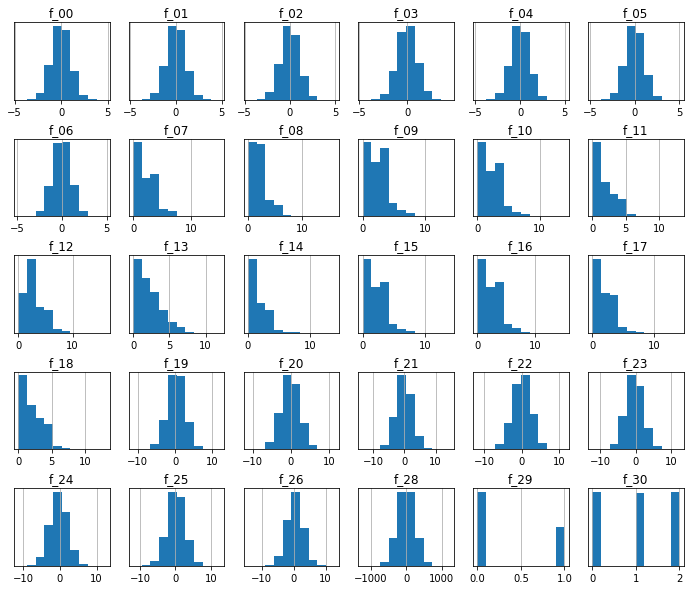

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)

col_explore = df.drop(columns=['target', 'id', 'f_27']).columns
k = 0

for i in range(len(col_explore)):
  ax = plt.subplot(5, 6, k + 1)
  df.drop(columns=['target', 'id', 'f_27'])[col_explore[k]].hist(ax=ax)
  ax.set_title(col_explore[k])
  ax.set_yticks([])
  k = k + 1
   
plt.show()

The histogram of some of the features look good. For thoroughness, we describe each column (feature)

In [ ]:
df['f_00'].describe()

count    900000.000000
mean         -0.000286
std           0.998888
min          -4.599856
25%          -0.675490
50%           0.001144
75%           0.674337
max           4.749301
Name: f_00, dtype: float64

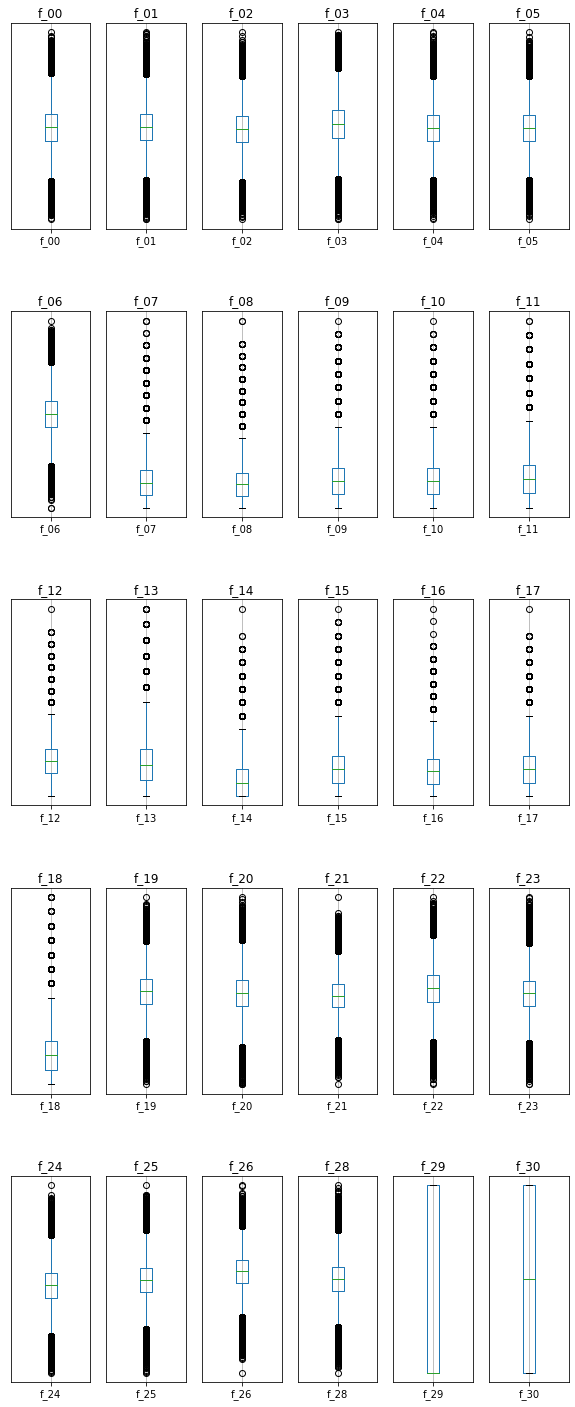

In [ ]:
plt.figure(figsize=(10, 25))
plt.subplots_adjust(hspace=0.4)

col_explore = df.drop(columns=['target', 'id', 'f_27']).columns
k = 0

for i in range(len(col_explore)):
  ax = plt.subplot(5, 6, k + 1)
  df.drop(columns=['target', 'id', 'f_27']).boxplot(ax=ax, column=col_explore[k])
  ax.set_title(col_explore[k])
  ax.set_yticks([])
  k = k + 1
   
plt.show()

Next, we check for colinearlity among the feature. But we drop 'f_27' first.

In [6]:
df.drop(columns='f_27', inplace=True)

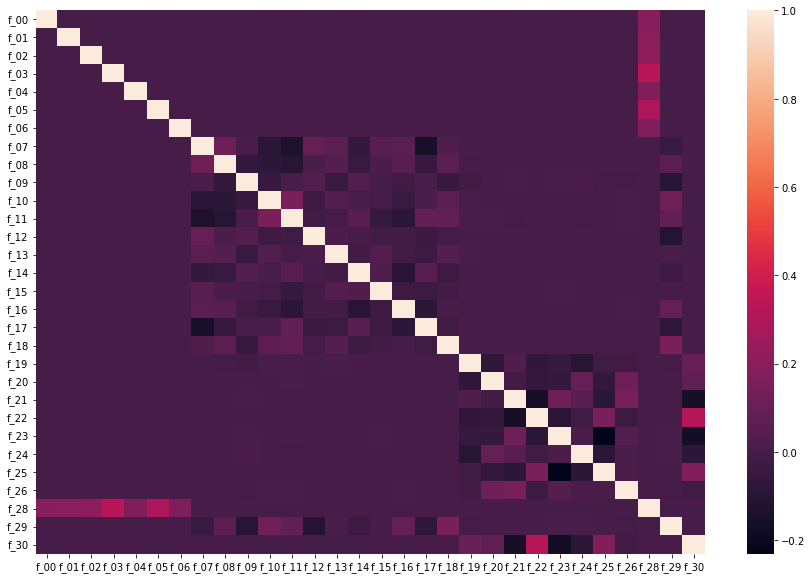

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.drop(columns=['target', 'id']).corr());

As we can see from the heat map above, there is hardly any colinearlity among the features.

## Feature Engineering

In [ ]:
f7_low, f7_high = df['f_07'].quantile([0.1, 0.9])
feat_df = df[df['f_07'].between(f7_low, f7_high)]

In [15]:
f8_low, f8_high = feat_df['f_08'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_08'].between(f8_low, f8_high)]

f9_low, f9_high = feat_df['f_09'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_09'].between(f9_low, f9_high)]

f10_low, f10_high = feat_df['f_10'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_10'].between(f10_low, f10_high)]

f11_low, f11_high = feat_df['f_11'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_11'].between(f11_low, f11_high)]

f12_low, f12_high = feat_df['f_12'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_12'].between(f12_low, f12_high)]

f13_low, f13_high = feat_df['f_13'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_13'].between(f13_low, f13_high)]

f14_low, f14_high = feat_df['f_14'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_14'].between(f14_low, f14_high)]

f15_low, f15_high = feat_df['f_15'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_15'].between(f15_low, f15_high)]

f16_low, f16_high = feat_df['f_16'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_16'].between(f16_low, f16_high)]

f17_low, f17_high = feat_df['f_17'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_17'].between(f17_low, f17_high)]

f18_low, f18_high = feat_df['f_18'].quantile([0.1, 0.9])
feat_df = feat_df[feat_df['f_18'].between(f18_low, f18_high)]

feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330942 entries, 9 to 899996
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      330942 non-null  int64  
 1   f_00    330942 non-null  float64
 2   f_01    330942 non-null  float64
 3   f_02    330942 non-null  float64
 4   f_03    330942 non-null  float64
 5   f_04    330942 non-null  float64
 6   f_05    330942 non-null  float64
 7   f_06    330942 non-null  float64
 8   f_07    330942 non-null  int64  
 9   f_08    330942 non-null  int64  
 10  f_09    330942 non-null  int64  
 11  f_10    330942 non-null  int64  
 12  f_11    330942 non-null  int64  
 13  f_12    330942 non-null  int64  
 14  f_13    330942 non-null  int64  
 15  f_14    330942 non-null  int64  
 16  f_15    330942 non-null  int64  
 17  f_16    330942 non-null  int64  
 18  f_17    330942 non-null  int64  
 19  f_18    330942 non-null  int64  
 20  f_19    330942 non-null  float64
 21  f_20    33

In [17]:
X = feat_df.drop(columns=['id', 'target'])
y = feat_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print('Shape of X_train is ', X_train.shape)
print('Shape of y_train is ', y_train.shape)
print('Shape of X_val is ', X_val.shape)
print('Shape of y_val is ', y_val.shape)

Shape of X_train is  (264753, 30)
Shape of y_train is  (264753,)
Shape of X_val is  (66189, 30)
Shape of y_val is  (66189,)


In [18]:
baseline = round(y.value_counts(normalize=True).max(), 2)
baseline

0.51

In [19]:
n_cols = min(X_train.shape)
clf_nn = Sequential([
  Dense(n_cols * 2, input_shape=(n_cols,), activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(1, activation='sigmoid')
])
clf_nn.compile(Adam(), 'binary_crossentropy', metrics=['Accuracy'])

In [22]:
clf_nn.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=[X_val, y_val])

Epoch 1/10
4137/4137 [==============================] - 11s 3ms/step - loss: 0.3206 - Accuracy: 0.8732 - val_loss: 0.3321 - val_Accuracy: 0.8665
Epoch 2/10
4137/4137 [==============================] - 10s 3ms/step - loss: 0.3194 - Accuracy: 0.8743 - val_loss: 0.3391 - val_Accuracy: 0.8646
Epoch 3/10
4137/4137 [==============================] - 11s 3ms/step - loss: 0.3175 - Accuracy: 0.8751 - val_loss: 0.3320 - val_Accuracy: 0.8669
Epoch 4/10
4137/4137 [==============================] - 11s 3ms/step - loss: 0.3158 - Accuracy: 0.8759 - val_loss: 0.3297 - val_Accuracy: 0.8687
Epoch 5/10
4137/4137 [==============================] - 11s 3ms/step - loss: 0.3145 - Accuracy: 0.8767 - val_loss: 0.3303 - val_Accuracy: 0.8692
Epoch 6/10
4137/4137 [==============================] - 10s 3ms/step - loss: 0.3138 - Accuracy: 0.8772 - val_loss: 0.3282 - val_Accuracy: 0.8688
Epoch 7/10
4137/4137 [==============================] - 11s 3ms/step - loss: 0.3123 - Accuracy: 0.8781 - val_loss: 0.3296 - val_Ac

## MODEL BUILDING

In [23]:
def wrangle(filepath):
  df = pd.read_csv(filepath).set_index('id')
  df.drop(columns='f_27', inplace=True)

  return df


In [24]:
X = df.drop(columns=['id', 'target'])
y = df['target']
X.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,...,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,67.609153,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,...,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,377.096415,0,0
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,...,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,-195.599702,0,2
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,...,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,210.826205,0,0
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,...,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,-217.211798,0,1


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print('Shape of X_train is ', X_train.shape)
print('Shape of y_train is ', y_train.shape)
print('Shape of X_val is ', X_val.shape)
print('Shape of y_val is ', y_val.shape)

Shape of X_train is  (720000, 30)
Shape of y_train is  (720000,)
Shape of X_val is  (180000, 30)
Shape of y_val is  (180000,)


Baseline:

In [ ]:
round(y.value_counts(normalize=True).max(), 2)

0.51

therefore the baseline of the model is about 51%

## Decision Tree Classifier

In [ ]:
clf = make_pipeline(DecisionTreeClassifier(random_state=42))
print(clf)


Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])


In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [ ]:
print('Accuracy Score for the Training Data is ', clf.score(X_train, y_train))
print('Accuracy Score for the Validation Data is ', clf.score(X_val, y_val))

Accuracy Score for the Training Data is  1.0
Accuracy Score for the Validation Data is  0.7208222222222223


As can be seen, the model performs exceptionally on training data, but fails to do so on validation data. Although, it beats baseline on both occassion, it does not generalize, and this is due to overfitting on training data.

Next, we try using Ensemble Model

## Random Forest Classifier

In [ ]:
clf_forest = make_pipeline(RandomForestClassifier())
print(clf_forest)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])


In [ ]:
clf_forest.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [ ]:
clf_forest.score(X_val, y_val)

0.8244277777777778

The Random Tree Classifier increase the accuracy on the validation set but could it get better.

Next we try another ensemble model

## Gradient Boosting

In [ ]:
clf_grad = GradientBoostingClassifier()

In [ ]:
clf_grad.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
clf_grad.score(X_train, y_train)

0.7366944444444444

In [ ]:
clf_grad.score(X_val, y_val)

0.7353611111111111

Unfortunately, Gradient Boosting does not have a better accuracy than the Random Forest Classifier

Since this is a multipurpose model, I plan on trying as much classification algorithm as possible.

Next, we try 

## XGBOOST

In [ ]:
clf_xgb = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)

In [ ]:
clf_xgb.fit(X_train, y_train)

XGBClassifier()

In [ ]:
clf_xgb.score(X_train, y_train)

0.7412305555555555

In [ ]:
clf_xgb.score(X_val, y_val)

0.7401388888888889

Well, XGBoost does perform better than the normal Gradient Boosting and is faster. But the accuracy still doesn't compare to the Random Forest Classsifier.

Next, we use

## K-Nearest Neighbors

In [ ]:
train_acc = dict()
val_acc = dict()
for k in range(5, 50, 5):
  start_time = time.time()
  clf_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=k))
  clf_knn.fit(X_train, y_train)
  train_acc['k'] = accuracy_score(y_train, clf_knn.predict(X_train))
  val_acc['k'] = accuracy_score(y_val, clf_knn.predict(X_val))
  time_elasped = time.time() - start_time
  print(f'For {k} neighbors, the model took {time_elasped} to complete')

In [ ]:
train_acc

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
clf_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=k))
clf_knn

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

How about using 
## Neural Networks

The data seems to be large enough (with 700,000 rows) for an neural network model

In [61]:
n_cols = min(X_train.shape)
clf_nn = Sequential([
  Dense(n_cols * 2, input_shape=(n_cols,), activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(1, activation='sigmoid')
])
clf_nn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 60)                1860      
                                                                 
 dense_38 (Dense)            (None, 60)                3660      
                                                                 
 dense_39 (Dense)            (None, 60)                3660      
                                                                 
 dense_40 (Dense)            (None, 60)                3660      
                                                                 
 dense_41 (Dense)            (None, 60)                3660      
                                                                 
 dense_42 (Dense)            (None, 60)                3660      
                                                                 
 dense_43 (Dense)            (None, 1)                

In [28]:
clf_nn.compile(Adam(), 'binary_crossentropy', metrics=['Accuracy'])

In [ ]:
clf_nn.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=[X_val, y_val])

In [31]:
models = [
  Sequential([
  Dense(n_cols * 2, input_shape=(n_cols,), activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(1, activation='sigmoid')
]), 

Sequential([
  Dense(n_cols * 2, input_shape=(n_cols,), activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(1, activation='sigmoid')
]), 

Sequential([
  Dense(n_cols * 2, input_shape=(n_cols,), activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(1, activation='sigmoid')
]), 

Sequential([
  Dense(n_cols * 2, input_shape=(n_cols,), activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(1, activation='sigmoid')
]), 

Sequential([
  Dense(n_cols * 2, input_shape=(n_cols,), activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(1, activation='sigmoid')
]), 
]

for model in models:
  model.compile(Adam(), 'binary_crossentropy', metrics=['Accuracy'])

In [35]:
def neural_cross_val(models, X, y, cv=5, epochs=10, batch_size=64):
  kf = KFold(n_splits=cv, shuffle=True)
  i = 0
  for train_index, test_index in kf.split(X):
    print('Training ', i, 'for', type(models[i]).__name__)
    models[i].fit(X.iloc[train_index], y.iloc[train_index], epochs=epochs, batch_size=batch_size, validation_data=[X.iloc[test_index], y.iloc[test_index]])
    i = i + 1


In [36]:
neural_cross_val(models, X_train, y_train)

Training  0 for Sequential
Epoch 1/10
9000/9000 [==============================] - 20s 2ms/step - loss: 0.5850 - Accuracy: 0.6926 - val_loss: 0.5262 - val_Accuracy: 0.7380
Epoch 2/10
9000/9000 [==============================] - 20s 2ms/step - loss: 0.4936 - Accuracy: 0.7633 - val_loss: 0.4563 - val_Accuracy: 0.7880
Epoch 3/10
9000/9000 [==============================] - 20s 2ms/step - loss: 0.4201 - Accuracy: 0.8130 - val_loss: 0.4129 - val_Accuracy: 0.8192
Epoch 4/10
9000/9000 [==============================] - 22s 2ms/step - loss: 0.3755 - Accuracy: 0.8413 - val_loss: 0.3650 - val_Accuracy: 0.8469
Epoch 5/10
9000/9000 [==============================] - 20s 2ms/step - loss: 0.3569 - Accuracy: 0.8527 - val_loss: 0.3538 - val_Accuracy: 0.8548
Epoch 6/10
9000/9000 [==============================] - 19s 2ms/step - loss: 0.3442 - Accuracy: 0.8600 - val_loss: 0.3369 - val_Accuracy: 0.8654
Epoch 7/10
9000/9000 [==============================] - 19s 2ms/step - loss: 0.3353 - Accuracy: 0.8655 

In [57]:
stack = StackingClassifierEstimator(neuralnet_models=models)

In [59]:
pred_cv = stack.create_pred_df(X_train, y_train)

In [60]:
pred_cv.head()

,nn0,nn1,nn2,nn3,nn4,target
0,0.104560,0.026087,0.118033,0.153249,0.046310,0
1,0.011686,0.019474,0.022732,0.015274,0.062490,0
2,0.992218,0.994551,0.950965,0.933800,0.973104,1
3,0.054295,0.030710,0.056276,0.077463,0.042403,0
4,0.909317,0.936684,0.900594,0.842717,0.880743,1


In [65]:
n_cols = min(pred_cv.drop(columns='target').shape)
clf_nn = Sequential([
  Dense(n_cols * 2, input_shape=(n_cols,), activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(1, activation='sigmoid')
])
clf_nn.compile(Adam(), 'binary_crossentropy', metrics=['Accuracy'])

In [ ]:
clf_nn.fit(pred_cv.drop(columns='target'), pred_cv['target'], epochs=50, batch_size=64)

In [68]:
test_df = wrangle('test.csv')
test_df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30
id,,,,,,,,,,,,,,,,,,,,,
900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,...,2.749347,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,99.478419,0,0
900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,...,1.080762,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,-65.993825,1,0
900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,4,...,-1.406712,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,-87.405622,0,1
900003,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,4,...,3.011085,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,-281.293460,0,0
900004,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,2,...,0.100594,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,25.629415,0,2


In [71]:
test_pred_df = stack.create_pred_df(test_df)
test_pred_df.head()

,nn0,nn1,nn2,nn3,nn4
0,0.958347,0.987253,0.951831,0.971547,0.985505
1,0.963831,0.966842,0.945337,0.961077,0.965165
2,0.009744,0.002876,0.002139,0.001706,0.000743
3,0.133126,0.088133,0.071537,0.082897,0.143601
4,0.741907,0.788486,0.872806,0.773599,0.609941


In [ ]:
test_pred = clf_nn.predict(test_pred_df)

In [85]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = test_pred.round(0).astype(int)
submission.head()


,id,target
0,900000,1
1,900001,1
2,900002,0
3,900003,0
4,900004,1


In [86]:
submission.to_csv('sample_submission.csv', index=False)

In [87]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,id,target
0,900000,1
1,900001,1
2,900002,0
3,900003,0
4,900004,1


## Using Tensorflow Decision Forest

In [ ]:
X_train_ds = X_train
X_train_ds['target'] = y_train
X_val_ds = X_val
X_val_ds['target'] = y_val

In [ ]:
X_train_ds = tfdf.pd_dataframe_to_tf_dataset(X_train_ds, label='target')
X_val_ds = tfdf.pd_dataframe_to_tf_dataset(X_val_ds, label='target')

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [ ]:
clf_tfforest = tfdf.RandomForestModel()
clf_tfforest.fit(X_train_ds)

Use /tmp/tmp3ozqpxbq as temporary training directory
Starting reading the dataset
719/720 [============================>.] - ETA: 0s
Dataset read in 0:00:25.041521
Training model
Model trained in 0:20:59.051689
Compiling model
720/720 [==============================] - 1293s 2s/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
clf_tfforest.compile(metrics=['accuracy'])
eval = clf_tfforest.evaluate(X_val_ds, return_dict=True)

for name, val in eval.items():
  print(f'{name}: {val:.4f}')

180/180 [==============================] - 27s 149ms/step - loss: 0.0000e+00 - accuracy: 0.7960
loss: 0.0000
accuracy: 0.7960


## Stacking

In [ ]:
models = [('rf', DecisionTreeClassifier()),
          ('svm', SVC()),
          ('nb', GaussianNB())]

In [ ]:
clf_stack = StackingClassifier(estimators=models, final_estimator=LogisticRegression())

In [ ]:
clf_stack.fit(X_train, y_train)

In [56]:
class StackingClassifierEstimator:
  trained_models = None
  accuracy = dict()
  # pred_df = None
  
  def __init__(self, estimators=None, final_estimator=None, neuralnet_models=None, cv=None):
    self.estimators = estimators
    self.neuralnet_models = neuralnet_models
    self.cv = cv
    self.final_estimator = final_estimator
    pass
  
  def fit(self, X, y):
    trained_models = []
    if self.estimators is not None:
      for model in self.estimators:
        self.accuracy[type(model).__name__] = list()
        if self.cv is not None and self.cv > 0:
          kf = KFold(n_splits=self.cv, shuffle=True)
          i = 1
          for train_index, test_index in kf.split(X):
            print(f'training KFold {i} for {model}')
            model.fit(X.iloc[train_index], y.iloc[train_index])
            self.accuracy[type(model).__name__].append(
                [
                model.score(X.iloc[train_index], y.iloc[train_index]), 
                model.score(X.iloc[test_index], y.iloc[test_index])
                ]
            )
            trained_models.append(model)
            i = i + 1
        else:
          print(f'training {model}')
          model.fit(X, y)
          self.accuracy[model].append(model.score(X, y))
          trained_models.append(model)
      self.trained_models = trained_models
    return trained_models

  # trained_models = trained_models

  def create_pred_df(self, X, y=None):
    preds = dict()
    # trained_models = self.fit(X, y)
    i = 0
    if self.trained_models is not None:
      for model in self.trained_models:
        preds[i] = model.predict(X)
        i = i + 1
    if self.neuralnet_models is not None:
      if type(self.neuralnet_models) is list:
        j = 0
        for model in self.neuralnet_models:
          preds['nn'+str(j)] = model.predict(X)[:,0]
          j = j + 1
      else:
        preds['nn'] = self.neuralnet_models.predict(X)[:,0]
    if y is not None:
      preds['target'] = y.values
    return pd.DataFrame(preds)

  def train(self, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5
    )
    self.fit(X_train, y_train)
    df = self.create_pred_df(X, y)
    X = df.drop(columns='target')
    y = df['target']
    if self.final_estimator is not None:
      print(f'Training final estimator -- {self.final_estimator}')
      self.final_estimator.fit(X, y)
      print(self.final_estimator.score(X, y))

  def predict(self, X):
    return self.final_estimator.predict(self.create_pred_df(X))

  def score(self, X, y):
    df = self.create_pred_df(X, y)
    return self.final_estimator.score(df.drop(columns='target'), df['target'])





In [ ]:
models = [RandomForestClassifier(), xgb.XGBClassifier(), GaussianNB(), LogisticRegression(max_iter=1000), SGDClassifier()]
m = StackingClassifierEstimator(models, DecisionTreeClassifier(), clf_nn, cv=5)

In [ ]:
m.train(X_train, y_train)

training KFold 1 for RandomForestClassifier()
training KFold 2 for RandomForestClassifier()
training KFold 3 for RandomForestClassifier()
training KFold 4 for RandomForestClassifier()
training KFold 5 for RandomForestClassifier()
training KFold 1 for XGBClassifier()
training KFold 2 for XGBClassifier()
training KFold 3 for XGBClassifier()
training KFold 4 for XGBClassifier()
training KFold 5 for XGBClassifier()
training KFold 1 for GaussianNB()
training KFold 2 for GaussianNB()
training KFold 3 for GaussianNB()
training KFold 4 for GaussianNB()
training KFold 5 for GaussianNB()
training KFold 1 for LogisticRegression(max_iter=1000)
training KFold 2 for LogisticRegression(max_iter=1000)
training KFold 3 for LogisticRegression(max_iter=1000)
training KFold 4 for LogisticRegression(max_iter=1000)
training KFold 5 for LogisticRegression(max_iter=1000)
training KFold 1 for SGDClassifier()
training KFold 2 for SGDClassifier()
training KFold 3 for SGDClassifier()
training KFold 4 for SGDClass

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.9974736111111111


In [ ]:
model = RandomForestClassifier()
type(model).__name__ + ' ' + str(2)

'RandomForestClassifier 2'

In [ ]:
m.score(X_val, y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.8261166666666667

In [ ]:
pd.DataFrame(m.accuracy)

,RandomForestClassifier,XGBClassifier,GaussianNB,LogisticRegression,SGDClassifier
0,"[1.0, 0.815375]","[0.7400208333333333, 0.7390138888888889]","[0.6258993055555555, 0.6259166666666667]","[0.6152256944444444, 0.6175]","[0.5293368055555555, 0.5303472222222222]"
1,"[1.0, 0.8171111111111111]","[0.7350833333333333, 0.7346527777777778]","[0.626125, 0.6261805555555555]","[0.6157986111111111, 0.6150416666666667]","[0.5516180555555555, 0.55075]"
2,"[1.0, 0.8156944444444445]","[0.7419166666666667, 0.7346527777777778]","[0.6259652777777778, 0.62725]","[0.6163854166666667, 0.6136111111111111]","[0.5602118055555556, 0.555625]"
3,"[0.9999965277777778, 0.8159722222222222]","[0.7413090277777777, 0.7376111111111111]","[0.6262534722222223, 0.6254027777777778]","[0.6156840277777778, 0.6151805555555555]","[0.5847118055555556, 0.5865833333333333]"
4,"[0.9999965277777778, 0.8145138888888889]","[0.7407708333333334, 0.7364305555555556]","[0.6259965277777778, 0.6254444444444445]","[0.6156006944444444, 0.6151805555555555]","[0.5908159722222223, 0.5911944444444445]"


In [ ]:
df2 = m.create_pred_df(X_train, y_train)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,nn,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.051432,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.012238,0
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.964378,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.049843,0
4,1,1,1,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0.875327,1


In [ ]:
df3 = m.create_pred_df(X_val, y_val)
X_ii = df3.drop(columns='target')
y_ii = df3['target']

In [ ]:
X_i = df2.drop(columns='target')
y_i = df2['target']
n_cols = min(X_i.shape)
model_2 = Sequential([
  Dense(n_cols * 2, input_shape=(n_cols,), activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(n_cols * 2, activation='relu'),
  Dense(1, activation='sigmoid')                  
])

In [ ]:
model_2.compile(Adam(), 'binary_crossentropy', metrics=['Accuracy'])

In [ ]:
model_2.fit(X_i, y_i, epochs=2, batch_size=64, validation_data=[X_ii, y_ii])

Epoch 1/2
11250/11250 [==============================] - 33s 3ms/step - loss: 0.2535 - Accuracy: 0.9056 - val_loss: 0.3401 - val_Accuracy: 0.8583
Epoch 2/2
11250/11250 [==============================] - 32s 3ms/step - loss: 0.2531 - Accuracy: 0.9055 - val_loss: 0.3516 - val_Accuracy: 0.8588


In [ ]:
mask = df2[df2['nn'].between(0.4, 0.6)]
# df2[mask].head()
mask

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,nn,target
31,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0.457152,1
44,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0.434332,0
48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.538046,0
49,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0.568418,0
90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.442512,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719948,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.426224,0
719951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.415296,0
719955,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0.476533,0
719984,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.468008,1


In [ ]:
m.score(X_val, y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.86315

In [ ]:
pd.DataFrame(m.accuracy).head()

(DecisionTreeClassifier(max_features='auto', random_state=1090449688), DecisionTreeClassifier(max_features='auto', random_state=1533477483), DecisionTreeClassifier(max_features='auto', random_state=765320332), DecisionTreeClassifier(max_features='auto', random_state=1371147489), DecisionTreeClassifier(max_features='auto', random_state=1756042758), DecisionTreeClassifier(max_features='auto', random_state=1401310737), DecisionTreeClassifier(max_features='auto', random_state=1124052573), DecisionTreeClassifier(max_features='auto', random_state=1515273250), DecisionTreeClassifier(max_features='auto', random_state=1279390989), DecisionTreeClassifier(max_features='auto', random_state=1783299282), DecisionTreeClassifier(max_features='auto', random_state=1737143472), DecisionTreeClassifier(max_features='auto', random_state=2121312711), DecisionTreeClassifier(max_features='auto', random_state=440587708), DecisionTreeClassifier(max_features='auto', random_state=40438340), DecisionTreeClassifier(max_features='auto', random_state=1209205934), DecisionTreeClassifier(max_features='auto', random_state=34641749), DecisionTreeClassifier(max_features='auto', random_state=1959556204), DecisionTreeClassifier(max_features='auto', random_state=1471187131), DecisionTreeClassifier(max_features='auto', random_state=1058061362), DecisionTreeClassifier(max_features='auto', random_state=727459185), DecisionTreeClassifier(max_features='auto', random_state=10674125), DecisionTreeClassifier(max_features='auto', random_state=1657433818), DecisionTreeClassifier(max_features='auto', random_state=766814899), DecisionTreeClassifier(max_features='auto', random_state=1248413419), DecisionTreeClassifier(max_features='auto', random_state=1626742259), DecisionTreeClassifier(max_features='auto', random_state=2115233630), DecisionTreeClassifier(max_features='auto', random_state=1561524226), DecisionTreeClassifier(max_features='auto', random_state=1441260437), DecisionTreeClassifier(max_features='auto', random_state=219261142), DecisionTreeClassifier(max_features='auto', random_state=1942473615), DecisionTreeClassifier(max_features='auto', random_state=529091109), DecisionTreeClassifier(max_features='auto', random_state=550189710), DecisionTreeClassifier(max_features='auto', random_state=559192002), DecisionTreeClassifier(max_features='auto', random_state=412912878), DecisionTreeClassifier(max_features='auto', random_state=1100460675), DecisionTreeClassifier(max_features='auto', random_state=447148799), DecisionTreeClassifier(max_features='auto', random_state=746317056), DecisionTreeClassifier(max_features='auto', random_state=1244793312), DecisionTreeClassifier(max_features='auto', random_state=695677628), DecisionTreeClassifier(max_features='auto', random_state=188054580), DecisionTreeClassifier(max_features='auto', random_state=671315807), DecisionTreeClassifier(max_features='auto', random_state=1155953589), DecisionTreeClassifier(max_features='auto', random_state=1798763838), DecisionTreeClassifier(max_features='auto', random_state=682829791), DecisionTreeClassifier(max_features='auto', random_state=1147355150), DecisionTreeClassifier(max_features='auto', random_state=1287695755), DecisionTreeClassifier(max_features='auto', random_state=1206687362), DecisionTreeClassifier(max_features='auto', random_state=1382273045), DecisionTreeClassifier(max_features='auto', random_state=347584490), DecisionTreeClassifier(max_features='auto', random_state=353034758), DecisionTreeClassifier(max_features='auto', random_state=1525768615), DecisionTreeClassifier(max_features='auto', random_state=1722942940), DecisionTreeClassifier(max_features='auto', random_state=66796090), DecisionTreeClassifier(max_features='auto', random_state=1804927968), DecisionTreeClassifier(max_features='auto', random_state=1551450538), DecisionTreeClassifier(max_features='auto', random_state=1090644349), DecisionTreeClassifier(max_features='auto', random_state=520183277), DecisionTreeClassifier(max_features